<a href="https://colab.research.google.com/github/jaysolanki031128-maker/Data-Science-Portfolio/blob/main/Notebook_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kruskal, mannwhitneyu
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [19]:
fg = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fear_greed_index.csv")
hist = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/historical_data.csv")

fg['Date'] = pd.to_datetime(fg['date'], errors='coerce').dt.date
fg_daily_value = fg.groupby('Date')['value'].mean().rename('sentiment_value').reset_index()

hist['Date'] = pd.to_datetime(hist['Timestamp IST'], errors='coerce').dt.date
hist['Closed PnL'] = pd.to_numeric(hist['Closed PnL'], errors='coerce')
hist['Size USD'] = pd.to_numeric(hist['Size USD'], errors='coerce')


daily = hist.groupby('Date').agg(
    trades_count = ('Account','count'),
    total_closed_pnl = ('Closed PnL','sum'),
    mean_closed_pnl = ('Closed PnL','mean'),
    median_closed_pnl = ('Closed PnL','median'),
    std_closed_pnl = ('Closed PnL','std'),
    median_size_usd = ('Size USD','median'),
    pct_long = ('Side', lambda x: (x.str.lower().eq('buy').mean()))).reset_index()


merged = daily.merge(fg[['Date','classification']], on='Date', how='left')
merged = merged.merge(fg_daily_value, on='Date', how='left')

merged.to_csv("merged_analysis.csv", index=False)

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

<Figure size 800x500 with 0 Axes>

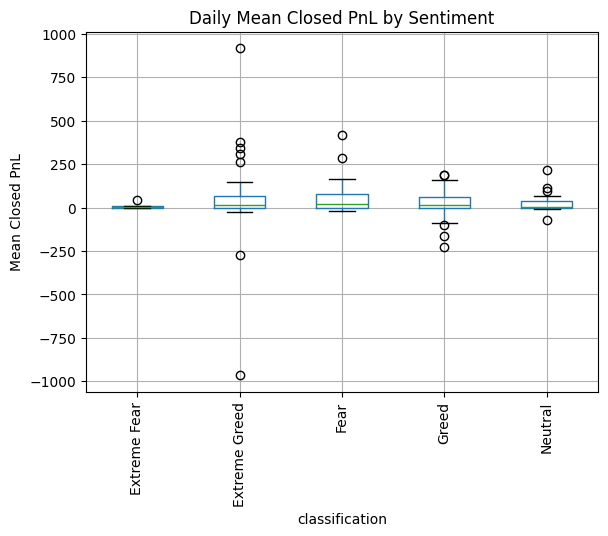

In [20]:
plt.figure(figsize=(8,5))
merged.boxplot(column='mean_closed_pnl', by='classification')
plt.title("Daily Mean Closed PnL by Sentiment")
plt.xticks(rotation=90)
plt.suptitle("")
plt.ylabel("Mean Closed PnL")
plt.plot

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

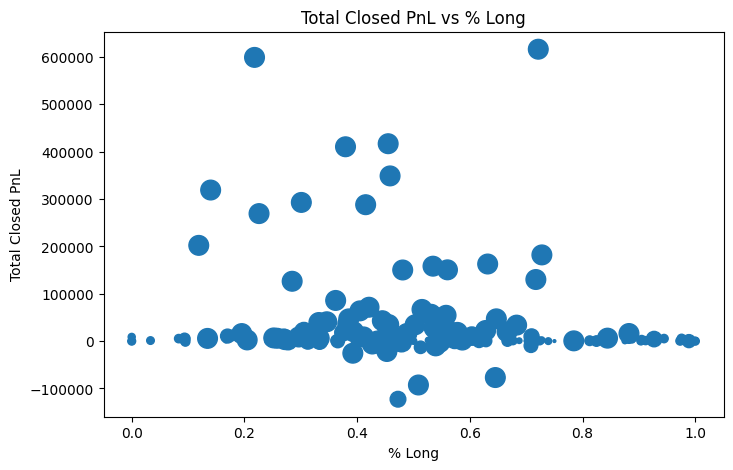

In [21]:
plt.figure(figsize=(8,5))
plt.scatter(merged['pct_long'], merged['total_closed_pnl'], s=merged['trades_count'].clip(1,200))
plt.title("Total Closed PnL vs % Long")
plt.xlabel("% Long")
plt.ylabel("Total Closed PnL")
plt.plot

<Figure size 800x500 with 0 Axes>

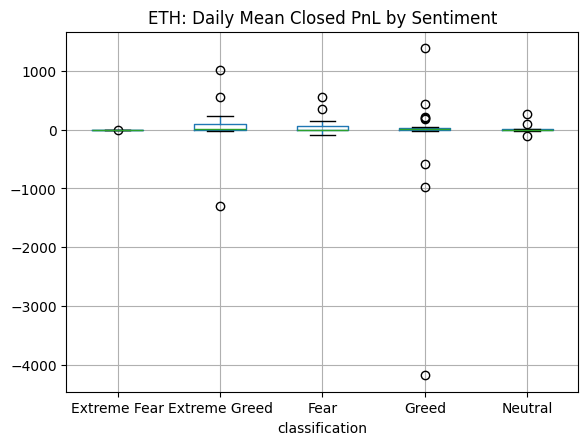

<Figure size 800x500 with 0 Axes>

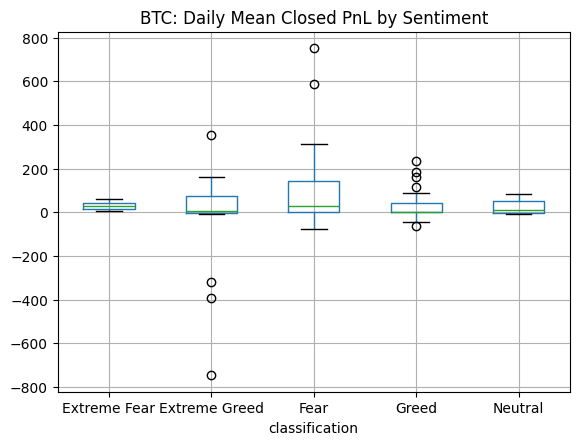

<Figure size 800x500 with 0 Axes>

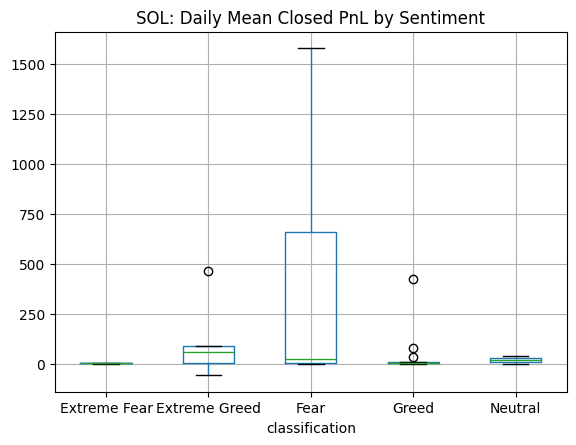

<Figure size 800x500 with 0 Axes>

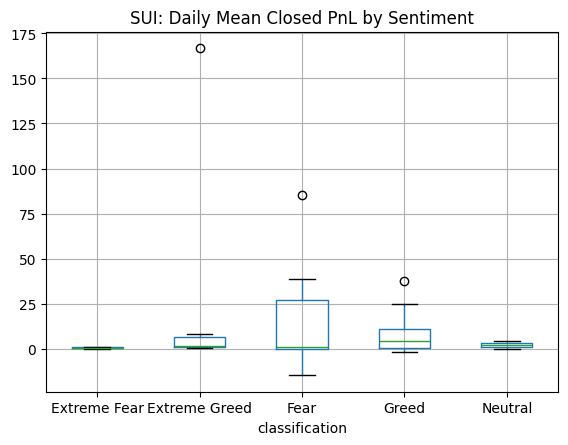

<Figure size 800x500 with 0 Axes>

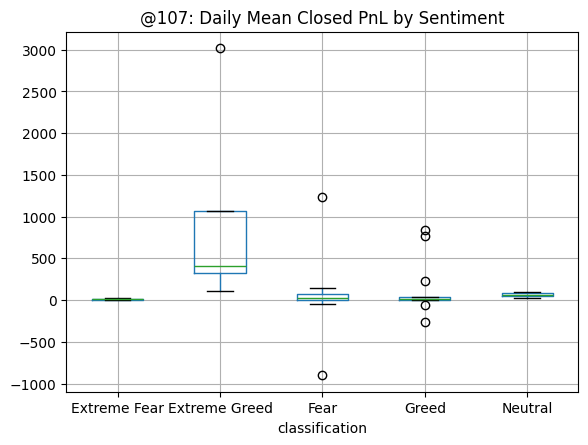

<Figure size 800x500 with 0 Axes>

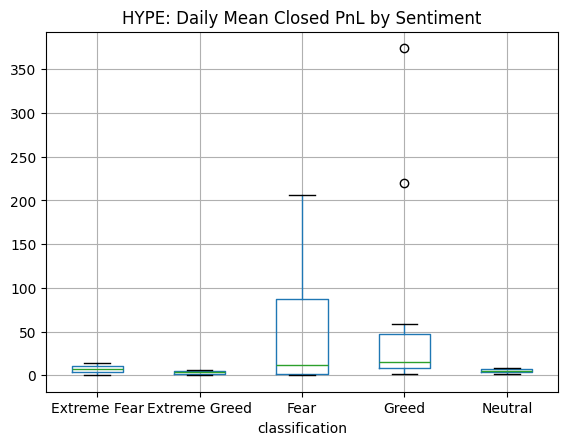

In [22]:
symbol_daily = hist.groupby(['Date','Coin']).agg(
    trades_count=('Account','count'),
    total_closed_pnl=('Closed PnL','sum'),
    mean_closed_pnl=('Closed PnL','mean')).reset_index()

symbol_daily = symbol_daily.merge(fg[['Date','classification']], on='Date', how='left')

top_symbols = symbol_daily['Coin'].value_counts().nlargest(6).index
for sym in top_symbols:
    data = symbol_daily[symbol_daily['Coin']==sym]
    plt.figure(figsize=(8,5))
    data.boxplot(column='mean_closed_pnl', by='classification')
    plt.title(f"{sym}: Daily Mean Closed PnL by Sentiment")
    plt.suptitle("")
    plt.plot

In [23]:
acc = hist.groupby('Account').agg(
    trades=('Account','count'),
    total_closed_pnl=('Closed PnL','sum'),
    mean_closed_pnl=('Closed PnL','mean'),
    std_closed_pnl=('Closed PnL','std'),
    wins=('Closed PnL', lambda x: (x>0).sum()),
    losses=('Closed PnL', lambda x: (x<=0).sum())).reset_index()

acc['sharpe_like'] = acc['mean_closed_pnl'] / acc['std_closed_pnl']
acc['win_rate'] = acc['wins'] / acc['trades']

print("Top 10 Accounts by Total PnL:")
print(acc.sort_values('total_closed_pnl', ascending=False).head(10))

print("Top 10 Accounts by Sharpe-like (>=50 trades):")
print(acc[acc['trades']>=50].sort_values('sharpe_like', ascending=False).head(10))

Top 10 Accounts by Total PnL:
                                       Account  trades  total_closed_pnl  \
27  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23   14733      2.143383e+06   
0   0x083384f897ee0f19899168e3b1bec365f52a9012    3818      1.600230e+06   
29  0xbaaaf6571ab7d571043ff1e313a9609a10637864   21192      9.401638e+05   
13  0x513b8629fe877bb581bf244e326a047b249c4ff1   12236      8.404226e+05   
31  0xbee1707d6b44d4d52bfe19e41f8a828645437aab   40184      8.360806e+05   
11  0x4acb90e786d897ecffb614dc822eb231b4ffb9f4    4356      6.777471e+05   
15  0x72743ae2822edd658c0c50608fd7c5c501b2afbd    1590      4.293556e+05   
9   0x430f09841d65beb3f27765503d0f850b8bce7713    1237      4.165419e+05   
16  0x72c6a4624e1dffa724e6d00d64ceae698af892a0    1430      4.030115e+05   
17  0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4    9893      3.790954e+05   

    mean_closed_pnl  std_closed_pnl   wins  losses  sharpe_like  win_rate  
27       145.481748     1374.026402   4967    9766     0.

In [24]:
merged = merged.sort_values('Date')
merged['target_t1_total_closed_pnl'] = merged['total_closed_pnl'].shift(-1)
merged['target_t2_total_closed_pnl'] = merged['total_closed_pnl'].shift(-2)

sub = merged.dropna(subset=['sentiment_value','target_t1_total_closed_pnl'])
print("Pearson r (t+1):", pearsonr(sub['sentiment_value'], sub['target_t1_total_closed_pnl']))
print("Spearman r (t+1):", spearmanr(sub['sentiment_value'], sub['target_t1_total_closed_pnl']))

Pearson r (t+1): PearsonRResult(statistic=np.float64(-0.11632604659736684), pvalue=np.float64(0.14552216290901604))
Spearman r (t+1): SignificanceResult(statistic=np.float64(-0.051279640427053526), pvalue=np.float64(0.5222518375796482))


In [25]:
groups = [merged.loc[merged['classification']==cls,'mean_closed_pnl'].dropna()
for cls in merged['classification'].dropna().unique()]
print("Kruskal-Wallis test:", kruskal(*groups))

greed = merged.loc[merged['classification']=="Greed",'mean_closed_pnl'].dropna()
fear = merged.loc[merged['classification']=="Fear",'mean_closed_pnl'].dropna()
if len(greed)>0 and len(fear)>0:
    print("Mann-Whitney Greed vs Fear:", mannwhitneyu(greed, fear, alternative='two-sided'))

Kruskal-Wallis test: KruskalResult(statistic=np.float64(3.770634505168993), pvalue=np.float64(0.43793604623161453))
Mann-Whitney Greed vs Fear: MannwhitneyuResult(statistic=np.float64(982.5), pvalue=np.float64(0.6766250149178592))


In [26]:
features = ['sentiment_value','pct_long','trades_count','median_size_usd','mean_closed_pnl']
merged['target'] = merged['total_closed_pnl'].shift(-1)

df = merged.dropna(subset=features+['target'])
dates = df['Date'].unique()
split = int(len(dates)*0.8)
train = df[df['Date']<=dates[split]]
test = df[df['Date']>dates[split]]

X_train, y_train = train[features], train['target']
X_test, y_test = test[features], test['target']

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Linear Regression
lr = LinearRegression().fit(X_train_s,y_train)
lr_pred = lr.predict(X_test_s)
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, lr_pred)))
print("Linear Regression R2:", r2_score(y_test, lr_pred))

# Random Forest
rf = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42).fit(X_train,y_train)
rf_pred = rf.predict(X_test)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_pred)))
print("Random Forest R2:", r2_score(y_test, rf_pred))

Linear Regression RMSE: 189444.73161280478
Linear Regression R2: -0.19217842241917582
Random Forest RMSE: 191933.6145631379
Random Forest R2: -0.22370934632874961
